In [27]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
import re
import cv2
import matplotlib.pyplot as plt
# from tensorflow.keras.utils import Sequence
import random
import plotly.express as px
from plotly.offline import init_notebook_mode

init_notebook_mode(connected=True)

In [28]:
data = pd.read_csv("train.csv")

In [29]:
data.head(10)

id        class segmentation
0  case123_day20_slice_0001  large_bowel          NaN
1  case123_day20_slice_0001  small_bowel          NaN
2  case123_day20_slice_0001      stomach          NaN
3  case123_day20_slice_0002  large_bowel          NaN
4  case123_day20_slice_0002  small_bowel          NaN
5  case123_day20_slice_0002      stomach          NaN
6  case123_day20_slice_0003  large_bowel          NaN
7  case123_day20_slice_0003  small_bowel          NaN
8  case123_day20_slice_0003      stomach          NaN
9  case123_day20_slice_0004  large_bowel          NaN

In [30]:
data.nunique()

id              38496
class               3
segmentation    33899
dtype: int64

## Dataset Structuring

In [31]:
df1 = data.pivot_table(values='segmentation',index='id',columns='class',aggfunc='max').reset_index()

In [32]:
df1

class                        id  \
0      case101_day20_slice_0066   
1      case101_day20_slice_0067   
2      case101_day20_slice_0068   
3      case101_day20_slice_0069   
4      case101_day20_slice_0070   
...                         ...   
16585    case9_day22_slice_0115   
16586    case9_day22_slice_0116   
16587    case9_day22_slice_0117   
16588    case9_day22_slice_0118   
16589    case9_day22_slice_0119   

class                                        large_bowel  \
0                                                    NaN   
1                                                    NaN   
2                                                    NaN   
3                                                    NaN   
4                                                    NaN   
...                                                  ...   
16585  38022 2 38380 7 38739 9 39099 10 39295 6 39459...   
16586  38021 4 38379 8 38739 10 38938 2 39099 10 3929...   
16587  38020 7 38379 10 38738 12 38936 4 39098 12 392...   
16588  37661 5 38019 10 38378 12 38738 12 39097 14 39...   
16589  37658 11 38017 13 38377 13 38737 13 39097 13 3...   

class                                        small_bowel  \
0                                                    NaN   
1                                                    NaN   
2                                                    NaN   
3                                                    NaN   
4                                                    NaN   
...                                                  ...   
16585  21360 7 21718 10 22077 12 22435 15 22788 1 227...   
16586  21361 3 21718 9 22076 12 22435 14 22794 17 231...   
16587  21717 8 22076 11 22434 15 22791 20 23149 25 23...   
16588  21359 6 21717 10 22074 15 22431 20 22790 23 23...   
16589  20998 7 21357 11 21714 15 22071 20 22430 22 22...   

class                                            stomach  
0      32107 5 32371 10 32635 13 32900 15 33165 17 33...  
1      31313 2 31577 7 31841 10 32105 14 32369 17 326...  
2      30517 2 30781 6 31046 9 31311 11 31575 15 3184...  
3      29981 10 30246 13 30511 16 30776 19 31041 21 3...  
4      28918 9 29182 14 29446 18 29711 21 29976 23 30...  
...                                                  ...  
16585                                                NaN  
16586                                                NaN  
16587                                                NaN  
16588                                                NaN  
16589                                                NaN  

[16590 rows x 4 columns]

In [33]:
df2 = data.drop_duplicates(subset=['id'])

In [34]:
df3 = pd.DataFrame(columns=['id','large_bowel','small_bowel','stomach'])
df3['id'] = df2[~df2['id'].isin(df1['id'])].id.values

## Restructured Dataframe: After Concatenation

In [35]:
data = pd.concat([df1,df3])
data.reset_index(inplace=True,drop=True)
data.head(10)

id  \
0  case101_day20_slice_0066   
1  case101_day20_slice_0067   
2  case101_day20_slice_0068   
3  case101_day20_slice_0069   
4  case101_day20_slice_0070   
5  case101_day20_slice_0071   
6  case101_day20_slice_0072   
7  case101_day20_slice_0073   
8  case101_day20_slice_0074   
9  case101_day20_slice_0075   

                                         large_bowel small_bowel  \
0                                                NaN         NaN   
1                                                NaN         NaN   
2                                                NaN         NaN   
3                                                NaN         NaN   
4                                                NaN         NaN   
5                                                NaN         NaN   
6                                                NaN         NaN   
7                                                NaN         NaN   
8  31080 6 31345 8 31610 10 31876 10 32142 10 324...         NaN   
9  30813 7 31078 10 31343 11 31609 12 31875 12 32...         NaN   

                                             stomach  
0  32107 5 32371 10 32635 13 32900 15 33165 17 33...  
1  31313 2 31577 7 31841 10 32105 14 32369 17 326...  
2  30517 2 30781 6 31046 9 31311 11 31575 15 3184...  
3  29981 10 30246 13 30511 16 30776 19 31041 21 3...  
4  28918 9 29182 14 29446 18 29711 21 29976 23 30...  
5  28117 12 28382 16 28647 18 28912 21 29177 24 2...  
6  27053 9 27317 14 27582 16 27847 19 28112 22 28...  
7  26786 9 27050 14 27314 18 27579 21 27844 23 28...  
8  26517 10 26781 16 27046 19 27311 22 27577 23 2...  
9  25984 12 26249 15 26514 18 26779 20 27044 23 2...

## Get Image Data
- Get Case ID, Day, Slice number
- Get the dimensions of the image
- Get the filepath of each image

In [36]:
data['case'] = data['id'].apply(lambda x: re.findall("\d+",x)[0])
data['day'] = data['id'].apply(lambda x: re.findall("\d+",x)[1])
data['slice'] = data['id'].apply(lambda x: re.findall("\d+",x)[2])

## Patient Data
- Case: Unique ID of a patient
- Day: Patients are expected to get their MRI scans done on multiple days
- Slice: Multiple images of several MRI scans done on a specific day

In [37]:
data

id large_bowel small_bowel  \
0      case101_day20_slice_0066         NaN         NaN   
1      case101_day20_slice_0067         NaN         NaN   
2      case101_day20_slice_0068         NaN         NaN   
3      case101_day20_slice_0069         NaN         NaN   
4      case101_day20_slice_0070         NaN         NaN   
...                         ...         ...         ...   
38491    case30_day0_slice_0140         NaN         NaN   
38492    case30_day0_slice_0141         NaN         NaN   
38493    case30_day0_slice_0142         NaN         NaN   
38494    case30_day0_slice_0143         NaN         NaN   
38495    case30_day0_slice_0144         NaN         NaN   

                                                 stomach case day slice  
0      32107 5 32371 10 32635 13 32900 15 33165 17 33...  101  20  0066  
1      31313 2 31577 7 31841 10 32105 14 32369 17 326...  101  20  0067  
2      30517 2 30781 6 31046 9 31311 11 31575 15 3184...  101  20  0068  
3      29981 10 30246 13 30511 16 30776 19 31041 21 3...  101  20  0069  
4      28918 9 29182 14 29446 18 29711 21 29976 23 30...  101  20  0070  
...                                                  ...  ...  ..   ...  
38491                                                NaN   30   0  0140  
38492                                                NaN   30   0  0141  
38493                                                NaN   30   0  0142  
38494                                                NaN   30   0  0143  
38495                                                NaN   30   0  0144  

[38496 rows x 7 columns]

## Image Path and Dimensions

In [38]:
path_df = pd.DataFrame(data=glob("train/*/*/*/*"),columns=['filepath'])


In [39]:
path_df['case'] = path_df['filepath'].apply(lambda x: re.findall("\d+",x)[1])
path_df['day'] = path_df['filepath'].apply(lambda x: re.findall("\d+",x)[2])
path_df['slice'] = path_df['filepath'].apply(lambda x: re.findall("\d+",x)[3])
path_df['width'] = path_df['filepath'].apply(lambda x: re.findall("\d+",x)[4])
path_df['height'] = path_df['filepath'].apply(lambda x: re.findall("\d+",x)[5])
path_df['pixel_x'] = path_df['filepath'].apply(lambda x: re.findall("\d+\.\d+",x)[0])
path_df['pixel_y'] = path_df['filepath'].apply(lambda x: re.findall("\d+\.\d+",x)[1])

In [40]:
data = data.merge(path_df, how='left', on=['case','day','slice'])

In [41]:
data.sort_values(by=['case','day','slice'],ignore_index=True, inplace=True)
data

id large_bowel small_bowel stomach case day  \
0      case101_day20_slice_0001         NaN         NaN     NaN  101  20   
1      case101_day20_slice_0002         NaN         NaN     NaN  101  20   
2      case101_day20_slice_0003         NaN         NaN     NaN  101  20   
3      case101_day20_slice_0004         NaN         NaN     NaN  101  20   
4      case101_day20_slice_0005         NaN         NaN     NaN  101  20   
...                         ...         ...         ...     ...  ...  ..   
38491    case92_day0_slice_0140         NaN         NaN     NaN   92   0   
38492    case92_day0_slice_0141         NaN         NaN     NaN   92   0   
38493    case92_day0_slice_0142         NaN         NaN     NaN   92   0   
38494    case92_day0_slice_0143         NaN         NaN     NaN   92   0   
38495    case92_day0_slice_0144         NaN         NaN     NaN   92   0   

      slice                                           filepath width height  \
0      0001  train/case101/case101_day20/scans/slice_0001_2...   266    266   
1      0002  train/case101/case101_day20/scans/slice_0002_2...   266    266   
2      0003  train/case101/case101_day20/scans/slice_0003_2...   266    266   
3      0004  train/case101/case101_day20/scans/slice_0004_2...   266    266   
4      0005  train/case101/case101_day20/scans/slice_0005_2...   266    266   
...     ...                                                ...   ...    ...   
38491  0140  train/case92/case92_day0/scans/slice_0140_266_...   266    266   
38492  0141  train/case92/case92_day0/scans/slice_0141_266_...   266    266   
38493  0142  train/case92/case92_day0/scans/slice_0142_266_...   266    266   
38494  0143  train/case92/case92_day0/scans/slice_0143_266_...   266    266   
38495  0144  train/case92/case92_day0/scans/slice_0144_266_...   266    266   

      pixel_x pixel_y  
0        1.50    1.50  
1        1.50    1.50  
2        1.50    1.50  
3        1.50    1.50  
4        1.50    1.50  
...       ...     ...  
38491    1.50    1.50  
38492    1.50    1.50  
38493    1.50    1.50  
38494    1.50    1.50  
38495    1.50    1.50  

[38496 rows x 12 columns]

## Removal of Poorly Annotated Data
- In the dicussions forum some of the cases were spotted out as poorly annotated
- We will remove these datapoints from our records

In [42]:
data['width'] = data['width'].astype(int)
data['height'] = data['height'].astype(int)

data = data[(data['case']!='7') & (data['day']!='0')].reset_index(drop=True)
data = data[(data['case']!='81') & (data['day']!='30')].reset_index(drop=True)
data = data[(data['case']!='138') & (data['day']!='00')].reset_index(drop=True)

In [43]:
data

id large_bowel small_bowel stomach case day  \
0      case101_day20_slice_0001         NaN         NaN     NaN  101  20   
1      case101_day20_slice_0002         NaN         NaN     NaN  101  20   
2      case101_day20_slice_0003         NaN         NaN     NaN  101  20   
3      case101_day20_slice_0004         NaN         NaN     NaN  101  20   
4      case101_day20_slice_0005         NaN         NaN     NaN  101  20   
...                         ...         ...         ...     ...  ...  ..   
25659   case90_day29_slice_0140         NaN         NaN     NaN   90  29   
25660   case90_day29_slice_0141         NaN         NaN     NaN   90  29   
25661   case90_day29_slice_0142         NaN         NaN     NaN   90  29   
25662   case90_day29_slice_0143         NaN         NaN     NaN   90  29   
25663   case90_day29_slice_0144         NaN         NaN     NaN   90  29   

      slice                                           filepath  width  height  \
0      0001  train/case101/case101_day20/scans/slice_0001_2...    266     266   
1      0002  train/case101/case101_day20/scans/slice_0002_2...    266     266   
2      0003  train/case101/case101_day20/scans/slice_0003_2...    266     266   
3      0004  train/case101/case101_day20/scans/slice_0004_2...    266     266   
4      0005  train/case101/case101_day20/scans/slice_0005_2...    266     266   
...     ...                                                ...    ...     ...   
25659  0140  train/case90/case90_day29/scans/slice_0140_266...    266     266   
25660  0141  train/case90/case90_day29/scans/slice_0141_266...    266     266   
25661  0142  train/case90/case90_day29/scans/slice_0142_266...    266     266   
25662  0143  train/case90/case90_day29/scans/slice_0143_266...    266     266   
25663  0144  train/case90/case90_day29/scans/slice_0144_266...    266     266   

      pixel_x pixel_y  
0        1.50    1.50  
1        1.50    1.50  
2        1.50    1.50  
3        1.50    1.50  
4        1.50    1.50  
...       ...     ...  
25659    1.50    1.50  
25660    1.50    1.50  
25661    1.50    1.50  
25662    1.50    1.50  
25663    1.50    1.50  

[25664 rows x 12 columns]

# Visualization: MRI Scans

In [44]:
def read_img(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED).astype("float32")
    return img

In [45]:
def display_images(temp_df):
    temp_df = temp_df.sample(15).reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    for i in range(15):
        plt.subplot(5 , 5, i+1)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        image = read_img(temp_df.loc[i,'filepath'])
        plt.imshow(image, cmap='gray')
        plt.title(f"{temp_df.loc[i,'id']}")

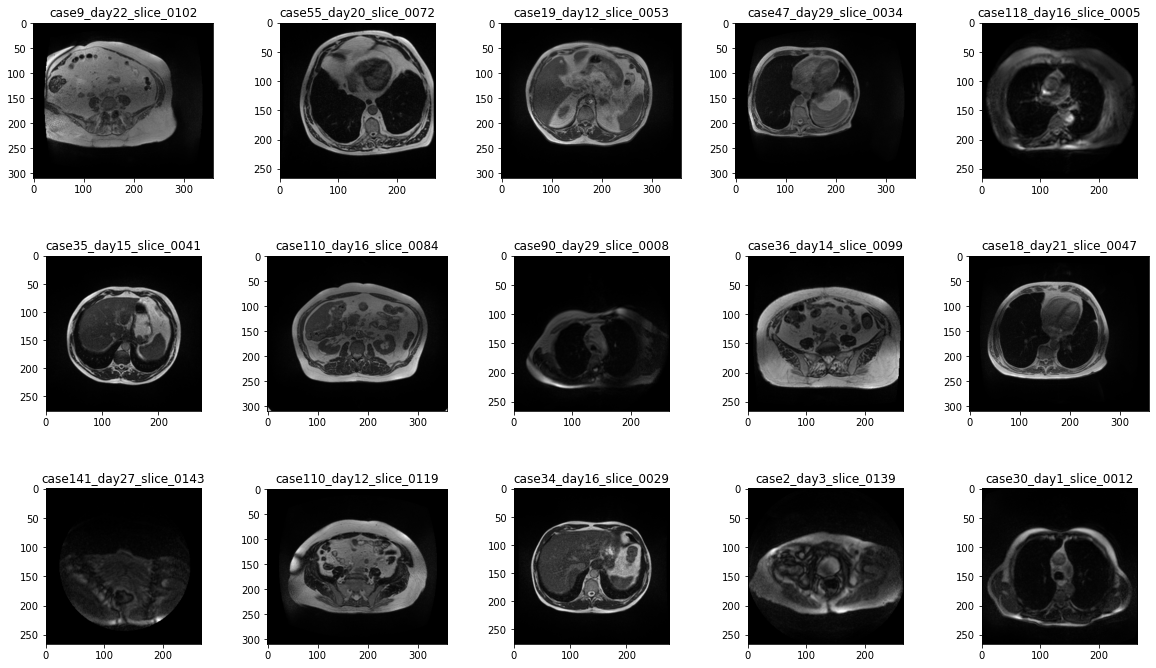

In [46]:
display_images(data)

In [47]:
def mask_from_rle(rle, shape):
    
    if type(rle) == float: # if nan
        return np.zeros(shape[0] * shape[1], dtype=np.uint8).reshape(shape)

    segm = np.asarray(rle.split(), dtype=int)
    start_point = segm[0::2] - 1
    length_point = segm[1::2]
    end_point = start_point + length_point
    case_mask = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    for start, end in zip(start_point, end_point):
        case_mask[start:end] = 255

    case_mask = case_mask.reshape((shape[0], shape[1]))
    
    return case_mask

## Visualization: Segmentation Masks
- For now lets visualize and see the segmentation masks individually
- We will put them together in single RGB mask next

In [48]:
def visual(temp_df,size):
    temp_df = temp_df.sample(size).reset_index(drop=True)
    for index in range(size):
        plt.figure(figsize=(20,10))
        image = read_img(temp_df['filepath'].iloc[index])
        plt.subplot(1,4,1)
        plt.imshow(image)
        plt.title("MRI Scan")
        plt.subplot(1,4,2)
        plt.imshow(mask_from_rle(temp_df['large_bowel'].iloc[index],(temp_df['height'].iloc[index],temp_df['width'].iloc[index])))
        plt.title("Large Bowel")
        plt.subplot(1,4,3)
        plt.imshow(mask_from_rle(temp_df['small_bowel'].iloc[index],(temp_df['height'].iloc[index],temp_df['width'].iloc[index])))
        plt.title("Small Bowel")
        plt.subplot(1,4,4)
        plt.imshow(mask_from_rle(temp_df['stomach'].iloc[index],(temp_df['height'].iloc[index],temp_df['width'].iloc[index])))
        plt.title("Stomach")


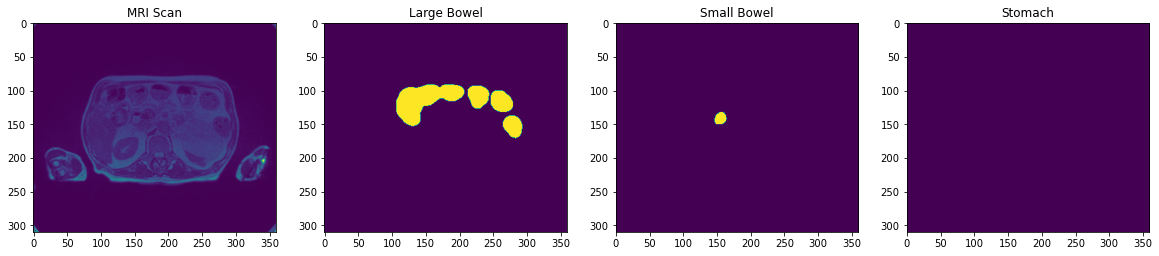

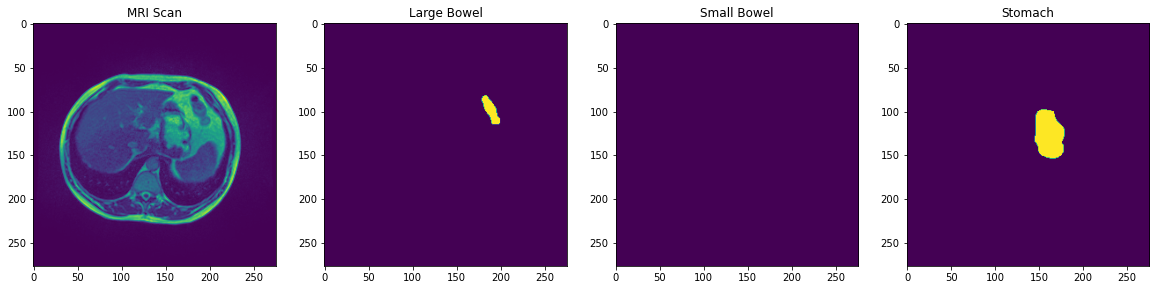

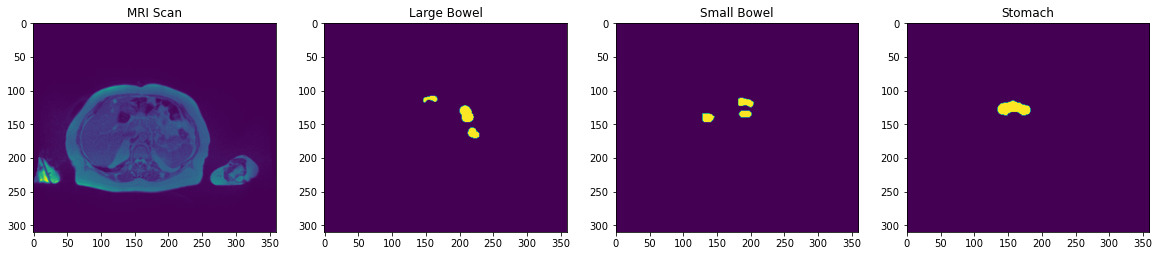

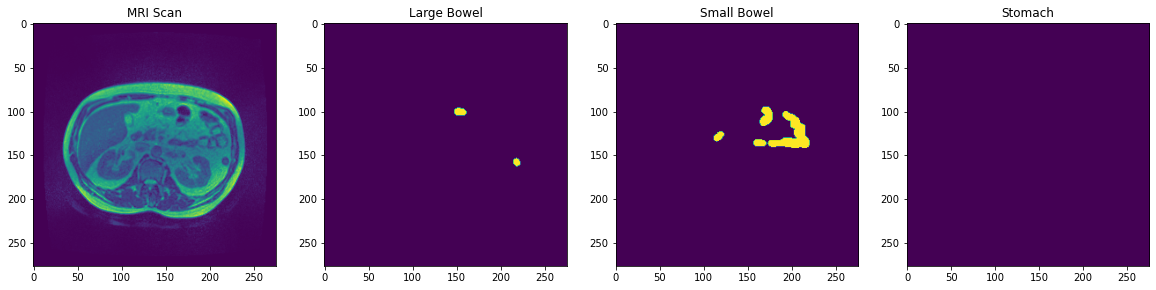

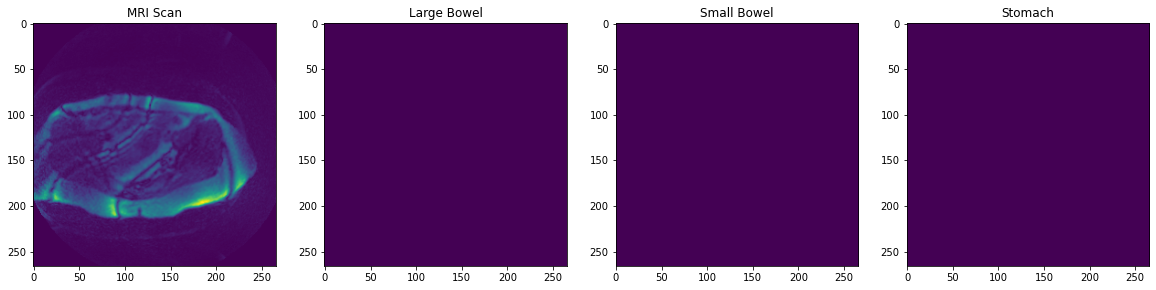

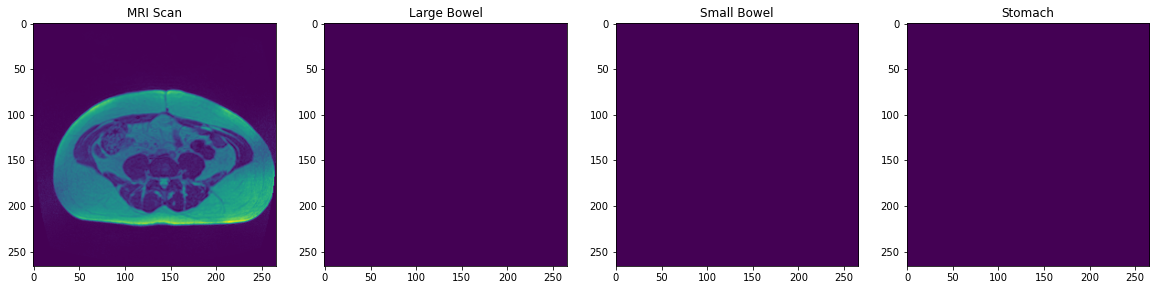

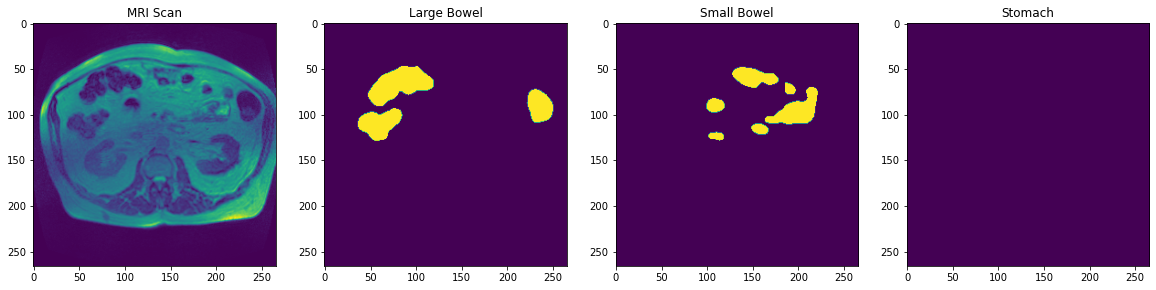

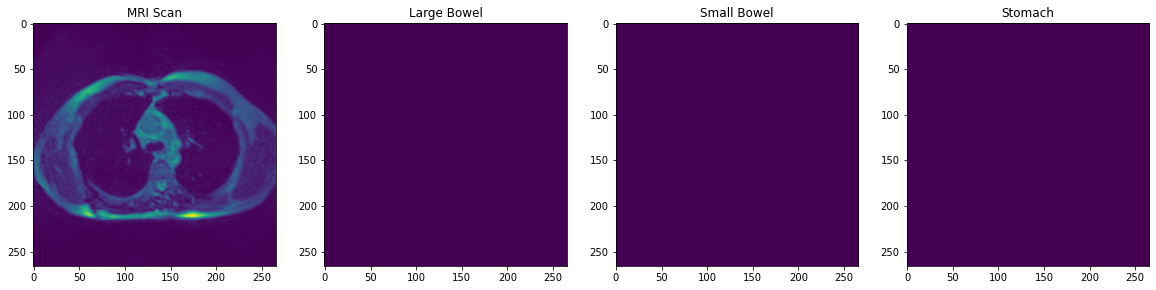

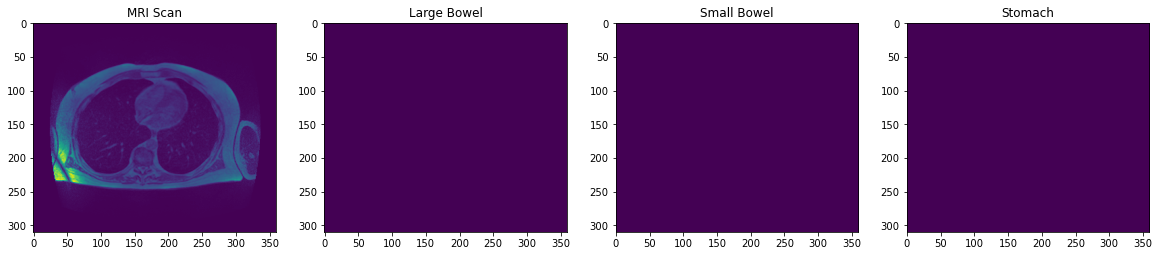

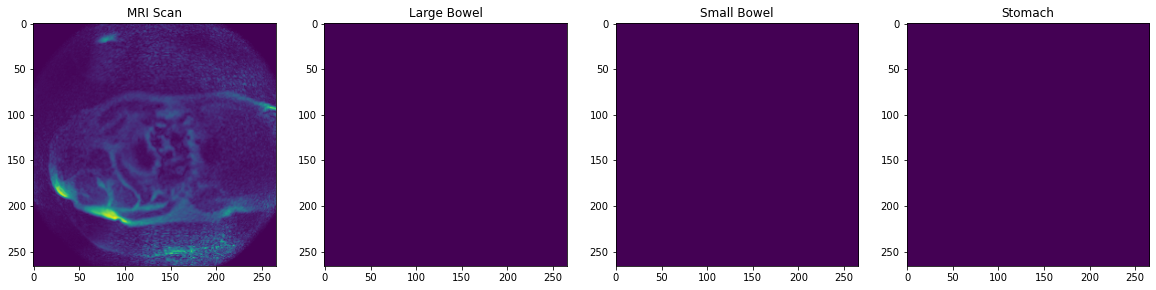

In [49]:
visual(data,10)

## Visualization: RGB Masks

In [50]:
def RGBMask(record):
    
    shape = (record['height'], record['width'], 3)
    mask = np.zeros(shape, dtype=np.uint8)
    
    small = mask_from_rle(record['small_bowel'],(record['height'],record['width']))
    large = mask_from_rle(record['large_bowel'],(record['height'],record['width']))
    stomach = mask_from_rle(record['stomach'],(record['height'],record['width']))
    
    mask[...,0] = large
    mask[...,1] = small
    mask[...,2] = stomach
    
    return mask

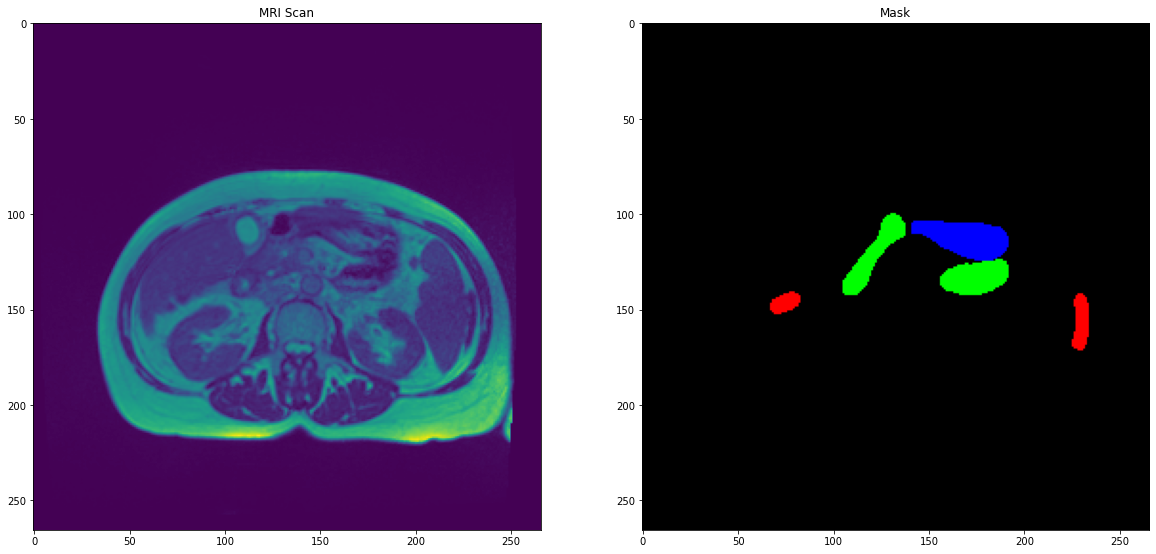

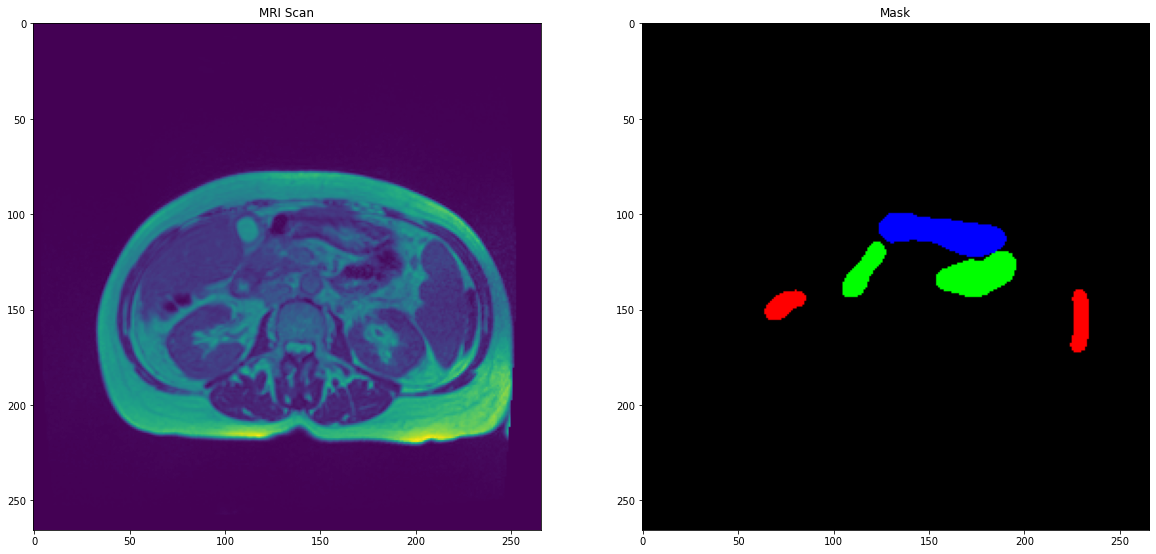

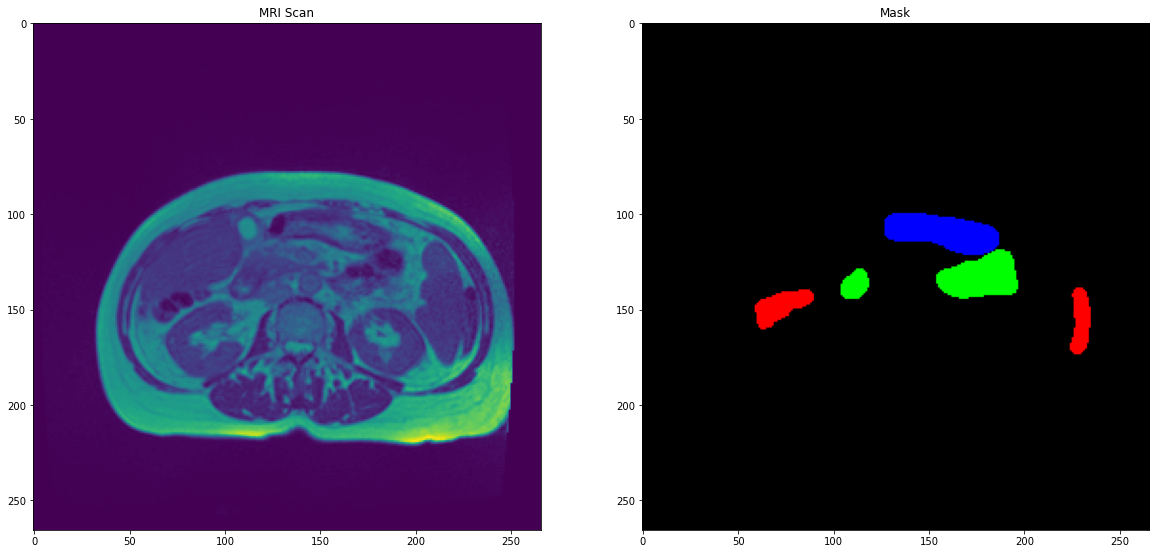

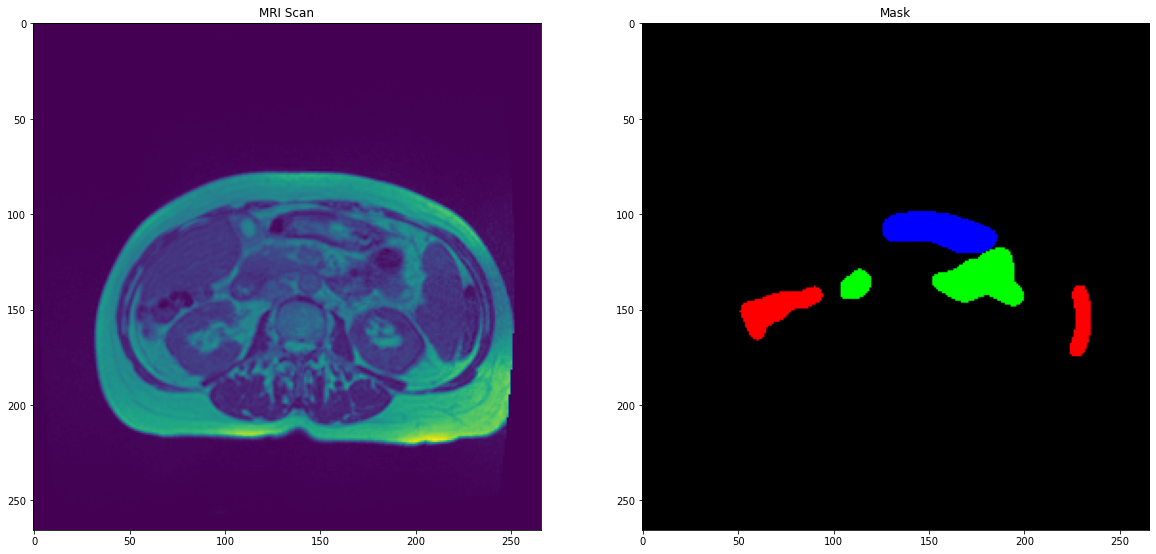

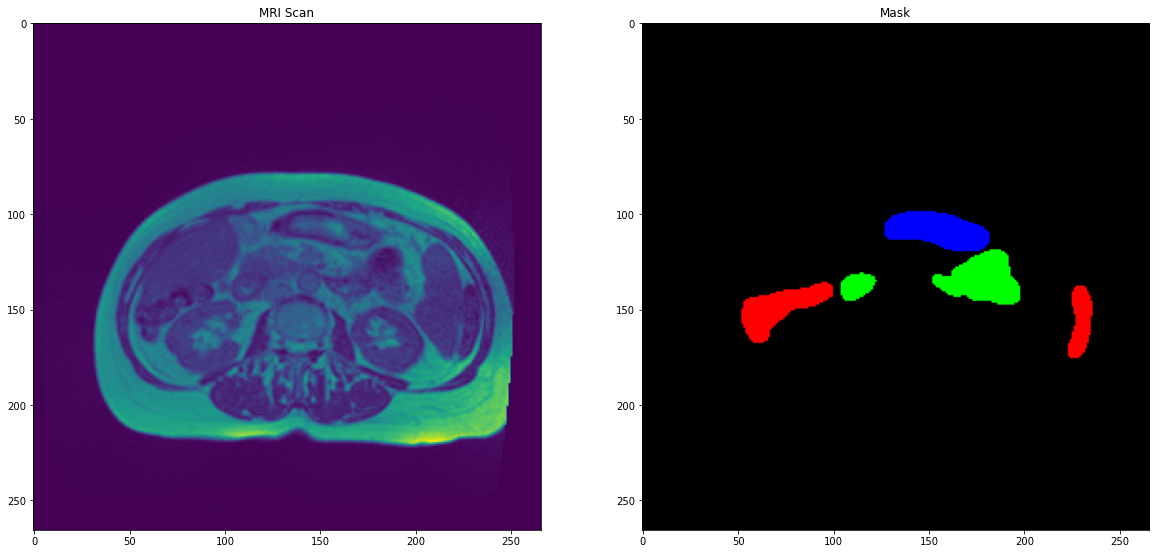

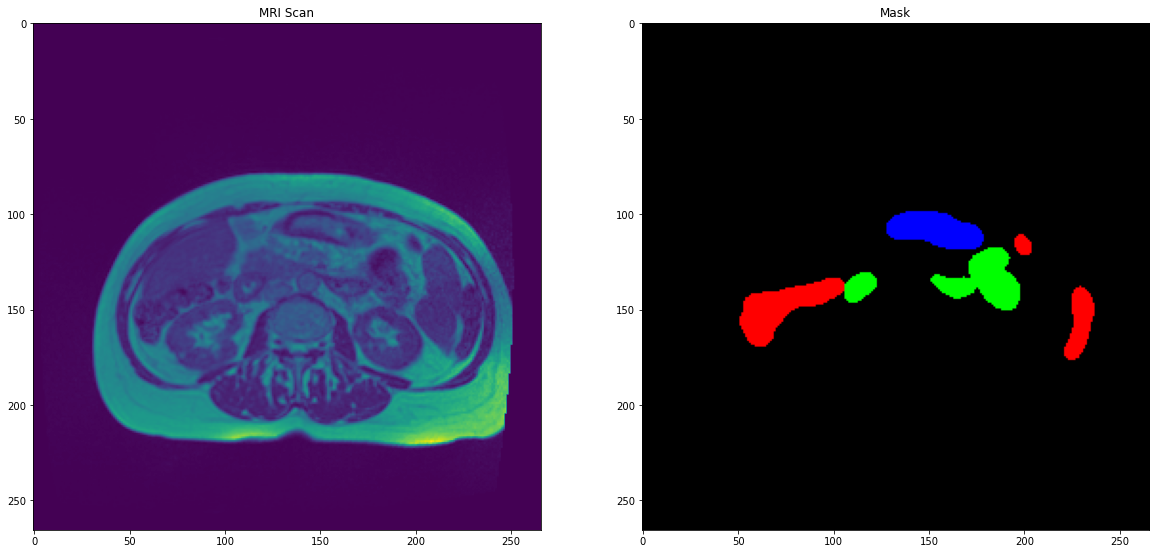

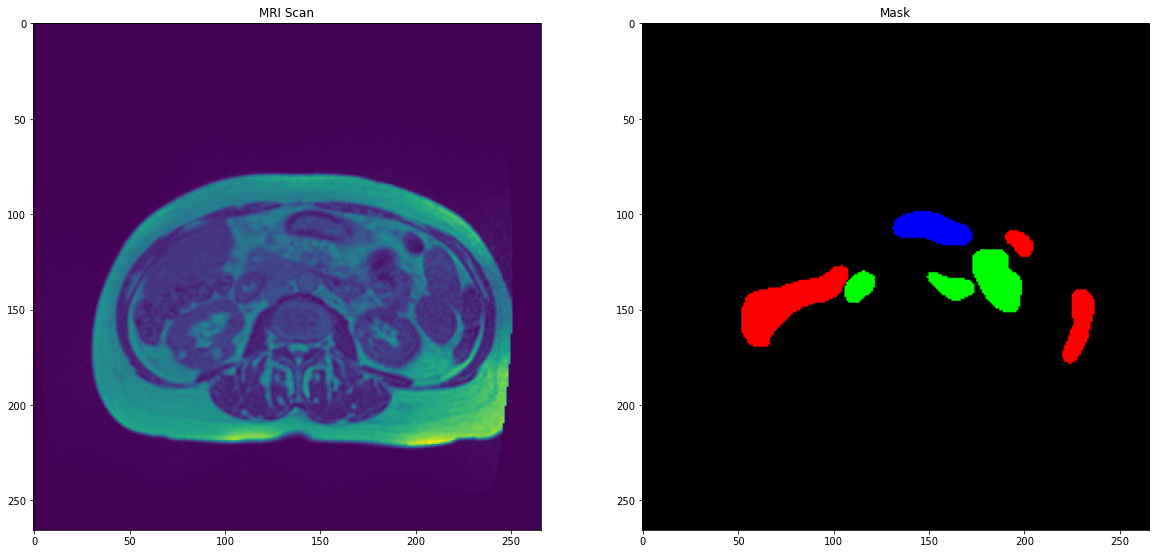

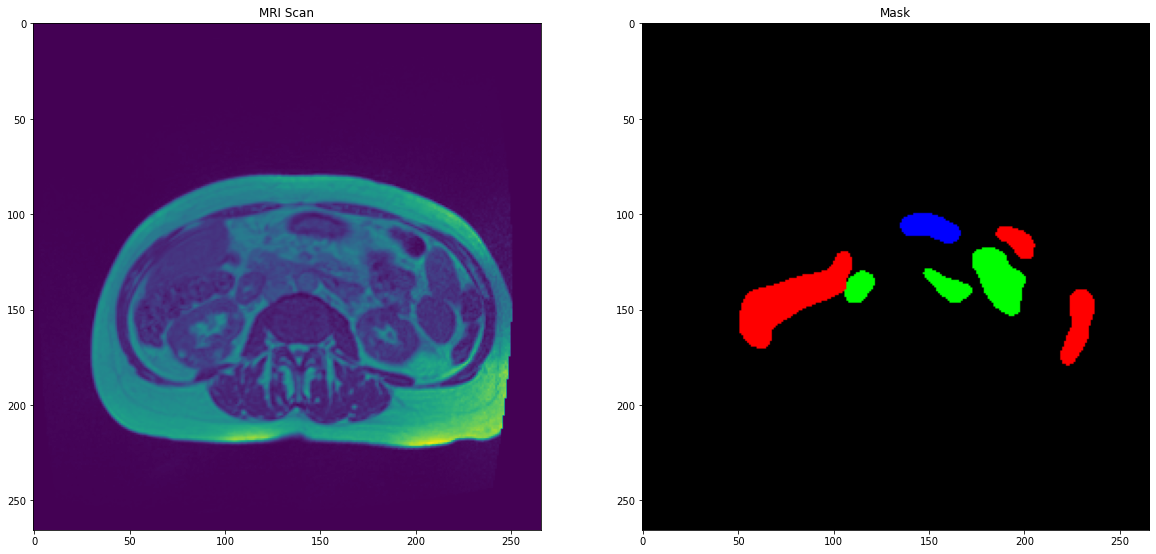

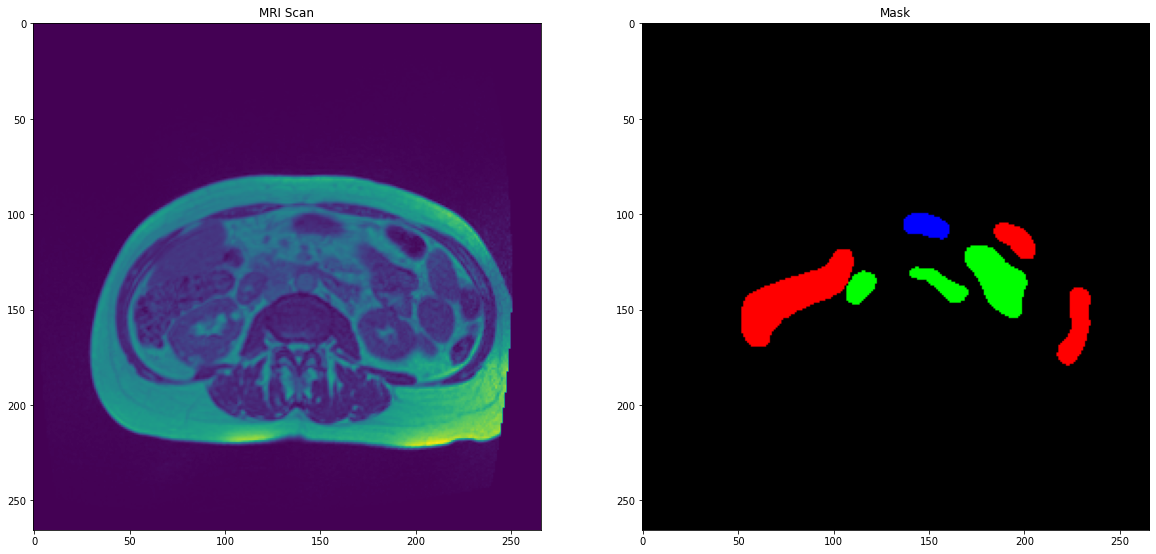

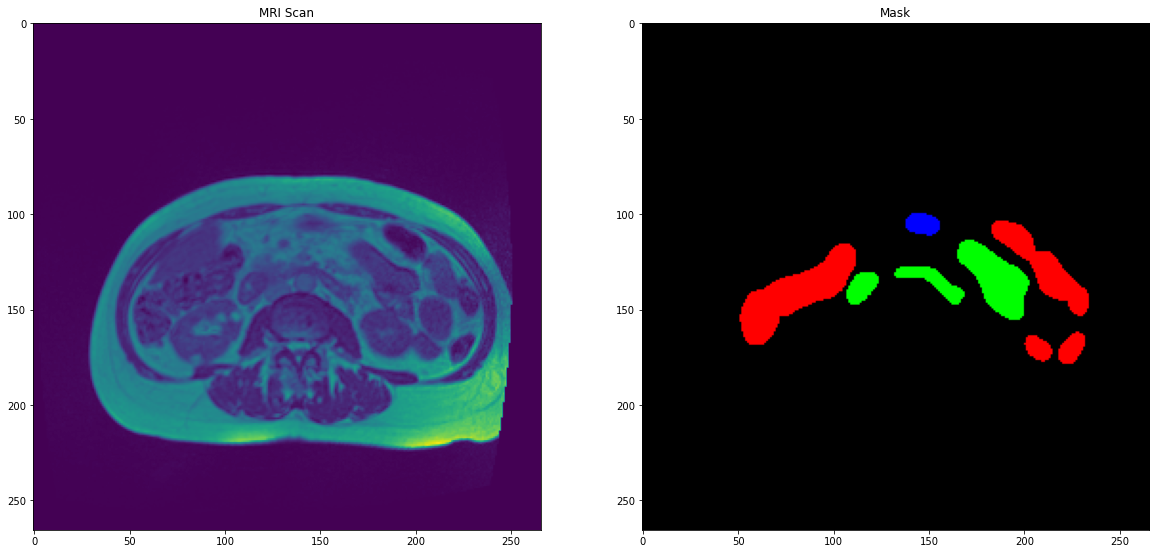

In [51]:
for index in data[data['stomach'].notna()].tail(10).index:
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.imshow(read_img(data.loc[index,'filepath']))
    plt.title("MRI Scan")
    plt.subplot(1,2,2)
    plt.imshow(RGBMask(data.loc[index,:]))
    plt.title("Mask")
    plt.show()

In [ ]:
## Making a custom Dataloader

In [108]:
import torch
import pandas as pd
import numpy as np

from tqdm import tqdm
import warnings
import torch.nn.functional as F
import PIL
import os
import torch
from torch.utils.data import DataLoader , WeightedRandomSampler
from glob import glob
import cv2
from torch import nn, optim
from torchvision.utils import make_grid

In [109]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self,dataframe,images_path,batch_size,transform=None,shuffle=False):
        self.df = dataframe
        self.image_path = images_path
        self.transform = transform
        self.batch_size = batch_size
        self.n = len(self.df)
    
    def __len__(self):
        return -(self.n // -self.batch_size)
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def mask_from_rle(self, rle, shape):
    
        if type(rle) == float: # if nan
            return np.zeros(shape[0] * shape[1], dtype=np.uint8).reshape(shape)

        segm = np.asarray(rle.split(), dtype=int)
        start_point = segm[0::2] - 1
        length_point = segm[1::2]
        end_point = start_point + length_point
        case_mask = np.zeros(shape[0]*shape[1], dtype=np.uint8)

        for start, end in zip(start_point, end_point):
            case_mask[start:end] = 255

        case_mask = case_mask.reshape((shape[0], shape[1]))

        return case_mask
    
    def RGBMask(self, record):
    
        shape = (record['height'], record['width'], 3)
        mask = np.zeros(shape, dtype=np.uint8)

        small = mask_from_rle(record['small_bowel'],(record['height'],record['width']))
        large = mask_from_rle(record['large_bowel'],(record['height'],record['width']))
        stomach = mask_from_rle(record['stomach'],(record['height'],record['width']))

        mask[...,0] = large
        mask[...,1] = small
        mask[...,2] = stomach

        return mask
    
    def read_img(self, path):
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED).astype("float32")
        return img
    
    def __get_data(self,batch):
        
        X = []
        y= []
        
        for index, record in batch.iterrows():
            image = read_img(batch.loc[index,self.image_path])
            mask = RGBMask(batch.loc[index,:])
            image = cv2.resize(image, (256,256))
            mask = cv2.resize(mask, (256,256))
            image = image / 255.
            mask = mask / 255.
            
            X.append(image)
            y.append(mask)
            
        X = np.array(X)
        y = np.array(y)
        
        return X,y
    
    def __getitem__(self,index):
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X, y = self.__get_data(batch)        
        return X, y

# Train - Test Split
- Before splitting the data lets look at the records of the number of days each patient in the data
- The competition rules already mention that the model should generalize well on
- New images of the previously seen cases
- New images of completely new cases
- You can try randomly shuffling the data as well, but here I have splitted the data with respect to the unique patients

In [68]:
fig = px.bar(data.groupby('case').count().reset_index(), x='case', y='filepath',title='Number of Days Per Case')
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})

In [69]:
cases = data['case'].unique().tolist()
random.shuffle(cases)

n = len(data)
train_set = cases[:int(n*0.82)]
test_set = cases[int(n*0.82):]

In [70]:
train = data[data['case'].isin(train_set)].reset_index(drop=True)
test = data[data['case'].isin(test_set)].reset_index(drop=True)          

In [75]:
train_generator = CustomDataset(train, 'filepath', batch_size=32)
test_generator = CustomDataset(test, 'filepath', batch_size=32,)

In [76]:
generate = train_generator[0]

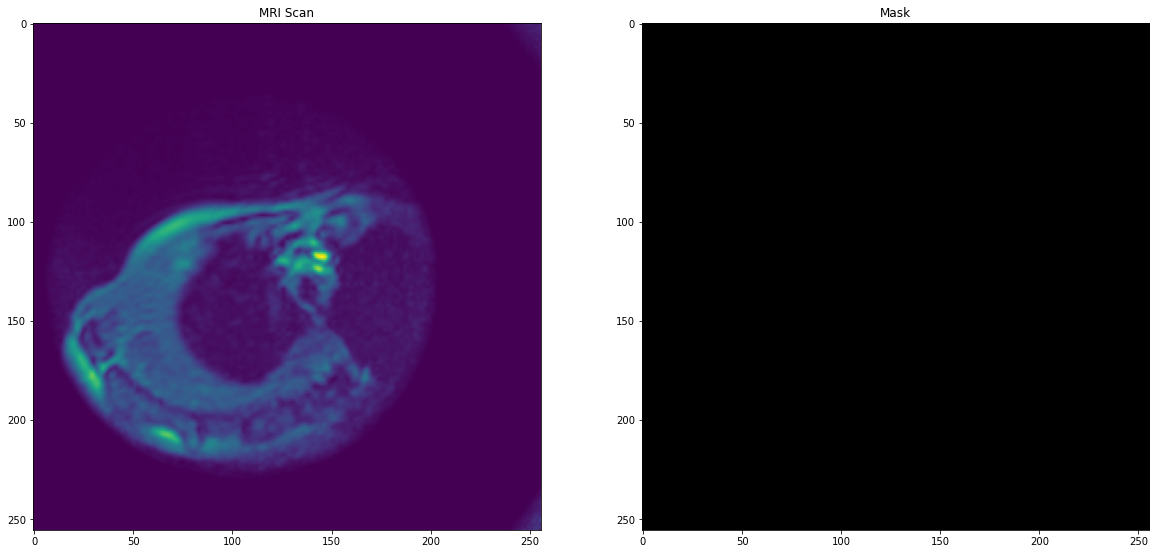

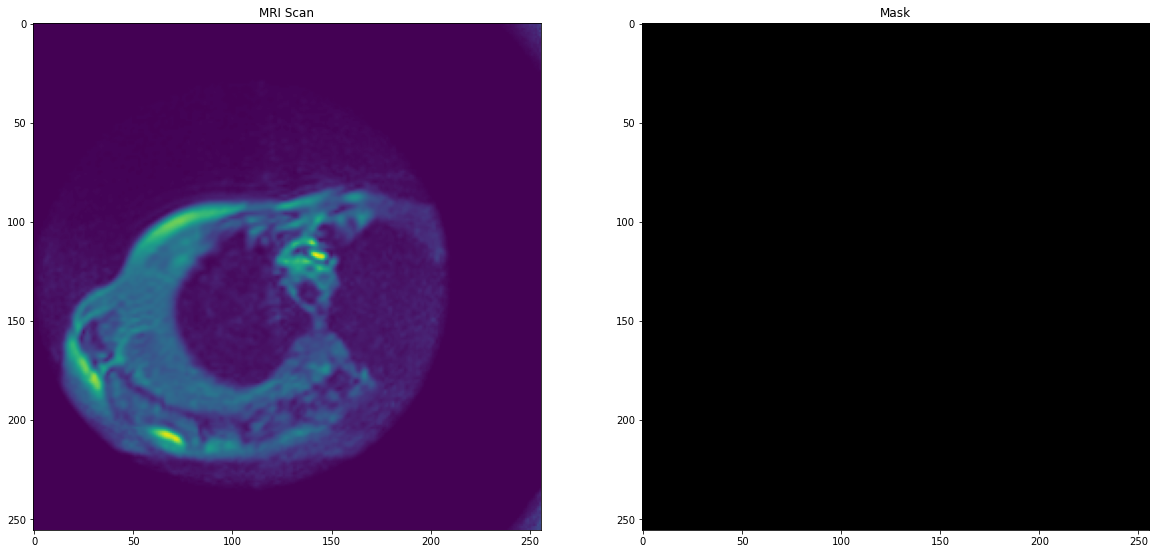

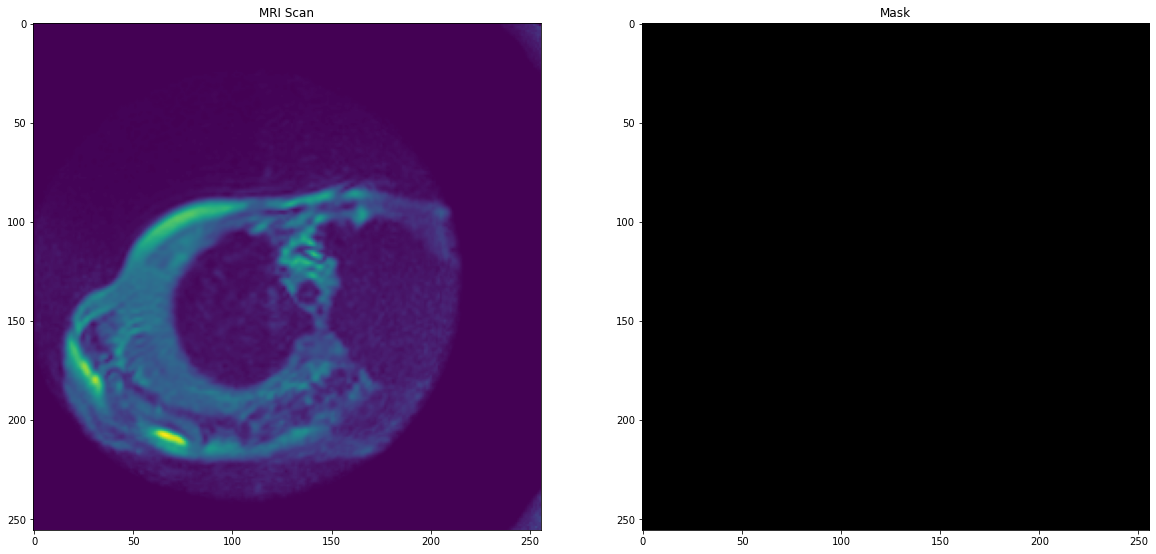

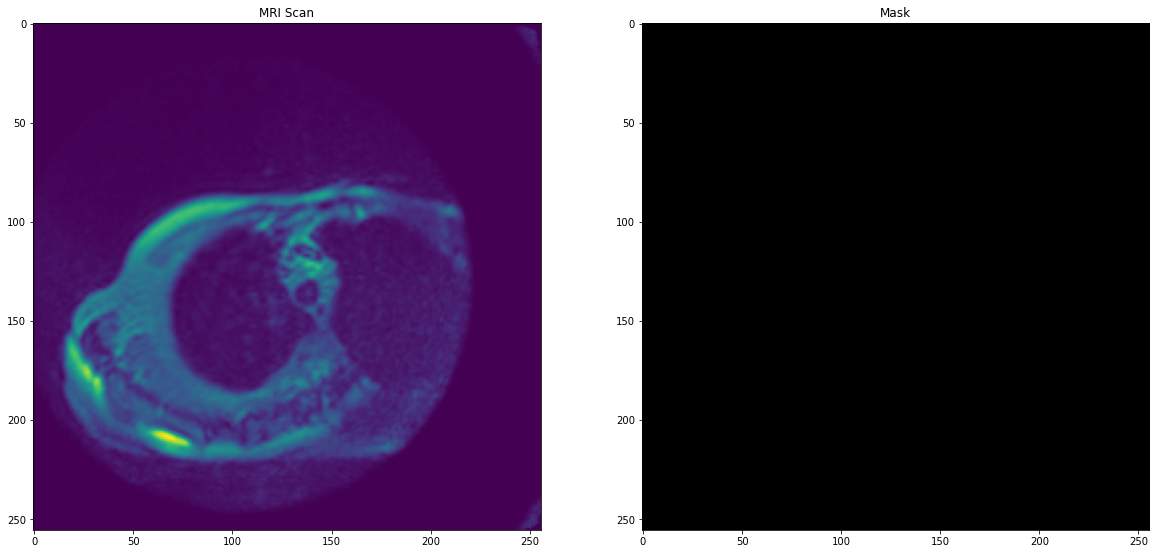

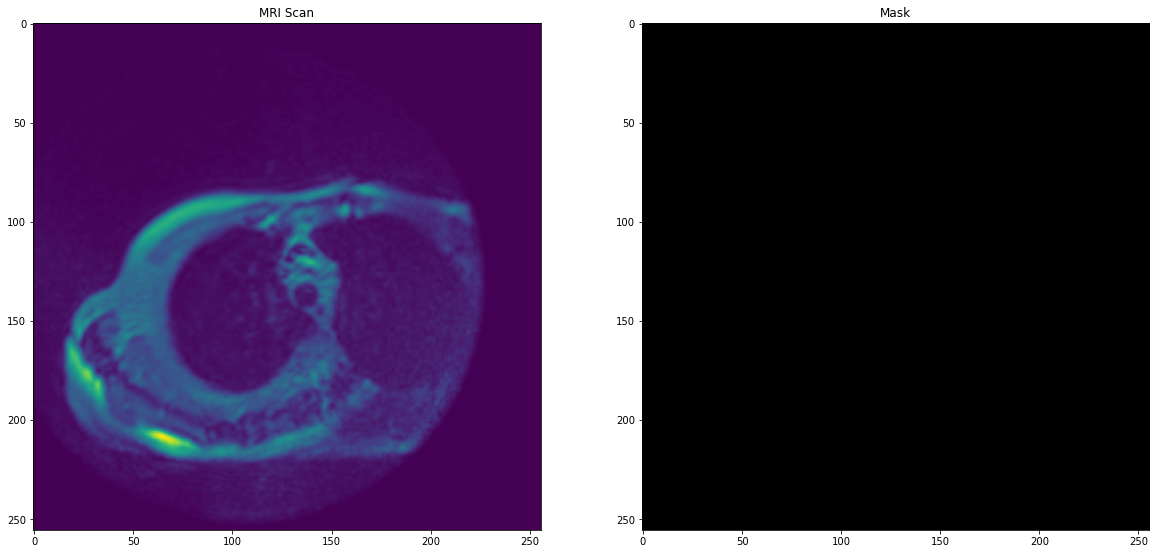

In [77]:
for i in range(5):
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.imshow(generate[0][i])
    plt.title("MRI Scan")
    plt.subplot(1,2,2)
    plt.imshow(generate[1][i])
    plt.title("Mask")
    plt.show()

In [82]:
train_loader = DataLoader(train_generator, batch_size=32,shuffle=False)
val_loader = DataLoader(test_generator, batch_size=32, shuffle=False)

In [90]:

for batch , (X,y) in enumerate(train_generator):
    print(X.shape)
    print(y.shape)
    break


(32, 256, 256)
(32, 256, 256, 3)


In [101]:
import segmentation_models_pytorch as smp

In [103]:
model = smp.UnetPlusPlus(
    encoder_name="resnext50_32x4d",        
    encoder_weights="imagenet",     
    in_channels=3,                  
    classes=3,
    activation='sigmoid'        
)


In [106]:
loss_fn  = smp.losses.TverskyLoss(mode='multilabel')

In [112]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = ExponentialLR(optimizer,gamma=0.9)

In [114]:
for b, (image, mask) in enumerate(train_loader):
  print(f"Shape of Image is : {image.shape}")
#   mask = mask.unsqueeze(1)
  print(f"Shape of mask is : {mask.shape}")
  print(f"Unique values in mask are : {torch.unique(mask)}")
  pred = model(image.to(device))
  print(f"Shape of Output Image is : {pred.shape}")
  # break
  print("---"*50)
  print("")

Shape of Image is : torch.Size([32, 32, 256, 256])
Shape of mask is : torch.Size([32, 32, 256, 256, 3])
Unique values in mask are : tensor([0.0000, 0.0039, 0.0078, 0.0118, 0.0157, 0.0196, 0.0235, 0.0275, 0.0314,
        0.0353, 0.0392, 0.0431, 0.0471, 0.0510, 0.0549, 0.0588, 0.0627, 0.0667,
        0.0706, 0.0745, 0.0784, 0.0824, 0.0863, 0.0902, 0.0941, 0.0980, 0.1020,
        0.1059, 0.1098, 0.1137, 0.1176, 0.1216, 0.1255, 0.1294, 0.1333, 0.1373,
        0.1412, 0.1451, 0.1490, 0.1529, 0.1569, 0.1608, 0.1647, 0.1686, 0.1725,
        0.1765, 0.1804, 0.1843, 0.1882, 0.1922, 0.1961, 0.2000, 0.2039, 0.2078,
        0.2118, 0.2157, 0.2196, 0.2235, 0.2275, 0.2314, 0.2353, 0.2392, 0.2431,
        0.2471, 0.2510, 0.2549, 0.2588, 0.2627, 0.2667, 0.2706, 0.2745, 0.2784,
        0.2824, 0.2863, 0.2902, 0.2941, 0.2980, 0.3020, 0.3059, 0.3098, 0.3137,
        0.3176, 0.3216, 0.3255, 0.3294, 0.3333, 0.3373, 0.3412, 0.3451, 0.3490,
        0.3529, 0.3569, 0.3608, 0.3647, 0.3686, 0.3725, 0.3765, 0.38

NameError: name 'device' is not defined